In [1]:
import os
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers

In [2]:
GPUs= tf.config.experimental.list_physical_devices("GPU")
if GPUs:
    try:
        for gpu in GPUs:
            tf.config.experimental.set_memory_growth(gpu,True)
        logical_gpus=tf.config.experimental.list_logical_devices("GPU")
        print(len(GPUs),"physical GPUs,",len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [3]:
ckpt_dir="./checkpoints/PGGAN"
re_dir="./results/PGGAN"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
if not os.path.exists(re_dir):
    os.makedirs(re_dir)

In [4]:
import ipynb_importer
from myutils import make_anime_dataset,visualize_result

importing Jupyter notebook from myutils.ipynb


In [5]:
def process_real_image(x,cur_res,alpha=1.0):
    x=tf.image.resize(x,(cur_res,cur_res))
    if (alpha >= 1.0) :
        return x
    else:
        y=tf.image.resize(x,(cur_res//2,cur_res//2))
        y=tf.image.resize(x,(cur_res,cur_res),method='bilinear')
        return lerp_clip(y,x,alpha)

def get_ckpt_path(cur_res):
    G_path=os.path.join(ckpt_dir,'generator{0}x{0}.h5'.format(cur_res))
    D_path=os.path.join(ckpt_dir,'discriminator{0}x{0}.h5'.format(cur_res))
    return D_path,G_path

def get_train_schedule(base_step=1000,increase_step=1000,target_res=64):
    res=4
    re={}
    while (res <= target_res):
        re[res]=base_step+increase_step*int(np.floor(np.log2(res/4)))
        res*=2
        
    return re
    
def prepare_model(resolution,G_before_D=False,load=False,same_res=False):
    D=Discriminator(resolution)
    G=Generator(resolution)
    
    if load is True:
        if not same_res:
            assert resolution > 4
            resolution=resolution//2
        D_path,G_path=get_ckpt_path(resolution)
        D.load_weights(D_path,by_name=True)
        G.load_weights(G_path,by_name=True)
    
    if G_before_D:
        return G,D
    else:
        return D,G

def prepare_optimizer(learning_rate,name):
    if (type(learning_rate) is float):
        d_lr=g_lr=learning_rate
    else:
        d_lr,g_lr=[learning_rate[0],learning_rate[1]]
    print('d_learning_rate={:.3e},g_learning_rate={:.3e}'.format(d_lr,g_lr))
    
    if (str.lower(name) == 'rmsprop'):
        d_optimizer= tf.keras.optimizers.RMSprop(learning_rate=d_lr)
        g_optimizer= tf.keras.optimizers.RMSprop(learning_rate=g_lr)
    elif (str.lower(name) == 'adam'):
        d_optimizer= tf.keras.optimizers.Adam(learning_rate=d_lr,beta_1=beta1,beta_2=beta2)
        g_optimizer= tf.keras.optimizers.Adam(learning_rate=g_lr,beta_1=beta1,beta_2=beta2)
    assert d_optimizer is not None
    return d_optimizer,g_optimizer

In [6]:
def Generator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((100,),name='GInput')
    alpha=layers.Input((1,),name='GAlpha')
    
    x=g_ConvBlock(2,name='g_block{0}x{0}'.format(4))(inputs)
    image=toRGB(name='toRGB{0}x{0}'.format(4))(x)
    
    for i in range(3,resolution_log2+1):
        cur_res=2**i
        x=g_ConvBlock(i,name='g_block{0}x{0}'.format(cur_res))(x)
        img=toRGB(name='toRGB{0}x{0}'.format(cur_res))(x)
        
        if (i == resolution_log2):
            image=layers.UpSampling2D(name='upsample{}to{}'.format(cur_res//2,cur_res))(image)
            image=lerp_clip(image,img,alpha)
        else:
            image=img
            
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=image)
    return model

In [7]:
# tf.keras.utils.plot_model(Generator(16),show_shapes=True)

In [8]:
def Discriminator(resolution=1024):
    resolution_log2=int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    
    inputs=layers.Input((resolution,resolution,3),name='DInput')
    alpha=layers.Input((1,),name='DAlpha')
    
    x=fromRGB(resolution_log2,name='fromRGB{0}x{0}'.format(resolution))(inputs)
    for i in range(resolution_log2,2,-1):
        cur_res=2**i
        x=d_ConvBlock(i,name='d_block{0}x{0}'.format(cur_res))(x)
        if (i == resolution_log2):
            img=layers.AvgPool2D(name='downsample{}'.format(i))(inputs)
            y=fromRGB(level=i-1,name='fromRGB{0}x{0}'.format(resolution//2))(img)
            x=lerp_clip(y,x,alpha)
    x=d_ConvBlock(2,name='d_block4x4')(x)
    
    model=tf.keras.Model(inputs=[inputs,alpha],outputs=x)
    return model

In [9]:
# tf.keras.utils.plot_model(Discriminator(8),show_shapes=True)

In [10]:
class Conv2D(layers.Conv2D):
    def __init__(self,filters,kernel_size=3,strides=1,padding='same',use_bias=True,activation=tf.nn.leaky_relu,lrmul=1.0,**kargs):
        super().__init__(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,
                         use_bias=use_bias,activation=activation,kernel_initializer='he_normal',**kargs)
        
        fan_in=self.filters*np.prod(self.kernel_size)
        self.he_std=np.float32(np.sqrt(2/fan_in))
        
        self.lrmul=tf.Variable(lrmul,name=self.name+'_lrmul',trainable=False)
        
    def build(self,input_shape):
        super().build(input_shape)
        
    def call(self,inputs):
        x=self._convolution_op(inputs,self.kernel * self.he_std * self.lrmul)
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias * self.lrmul,data_format='NHWC')
        if self.activation is not None:
            x=self.activation(x)
        return x
    
class Dense(layers.Dense):
    def __init__(self,filters,use_bias=True,activation=tf.nn.leaky_relu,lrmul=1.0,**kargs):
        super().__init__(filters,use_bias=use_bias,activation=activation,kernel_initializer='he_normal',**kargs)
        
        fan_in=self.units
        self.he_std=np.float32(np.sqrt(2/fan_in))
        
        self.lrmul=tf.Variable(lrmul,name=self.name+'_lrmul',trainable=False)
        
    def build(self,input_shape):
        super().build(input_shape)
        
    def call(self,inputs):
        if (len(inputs.shape) > 2):
            inputs=tf.reshape(inputs,[-1,np.prod(x.shape[1:])])
        
        x=tf.matmul(inputs,self.kernel * self.he_std * self.lrmul)
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias * self.lrmul,data_format='NHWC')
        if self.activation is not None:
            x=self.activation(x)
        return x    

In [11]:
class WScaleLayer(layers.Layer):
    def __init__(self,layer,activation=None,name=None,use_bias=True,**kargs):
        super(WScaleLayer,self).__init__(name=name)
        
        if name is None: name=''
        if isinstance(layer,layers.Dense):
            self.filters=K.get_value(layer.units)
            fan_in=self.filters
        elif isinstance(layer,layers.Conv2D):
            self.filters=K.get_value(layer.filters)
            fan_in=K.get_value(layer.filters)*np.prod(K.get_value(layer.kernel_size))
        else:
            raise TypeError
            
        std=np.float32(np.sqrt(2/fan_in))
        self.wscale=self.add_weight(name=name+'_wscale',shape=std.shape,trainable=False)
        K.set_value(self.wscale,std)
        
        self.activation=activation
        self.use_bias=use_bias
        
    def build(self,input_shape):
        if self.use_bias:
            self.bias = self.add_weight(name=self.name+'_bias',shape=(self.filters,),trainable=True)
        
    def call(self,inputs):
        x=inputs*self.wscale
        if self.use_bias:
            x=tf.nn.bias_add(x,self.bias,data_format='NHWC')
        if self.activation:
            x=self.activation(x)
        return x    
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [12]:
class g_ConvBlock(tf.keras.Model):
    def __init__(self,level,kernel_size=3,norm_latent=True,name=None):
        super(g_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        self.norm_latent=norm_latent
        
        if level > 2:
            self.upsample=layers.UpSampling2D(interpolation='bilinear',name=name+'_upsample')
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv2')
        else:
            self.fc=Dense(nf(1)*16,name=name+'_dense')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
            
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.upsample(inputs)
            x=PN(self.conv1(x))
            x=PN(self.conv2(x))
        else:
            if self.norm_latent:
                inputs=PN(inputs)
            x=PN(self.fc(inputs))
            x=tf.reshape(x,[-1,4,4,nf(1)])
            x=PN(self.conv(x))
        
        return x
    
class toRGB(tf.keras.Model):
    def __init__(self,filters=3,name=None):
        super(toRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=filters,kernel_size=1,strides=1,activation=None,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x
    
class d_ConvBlock(tf.keras.Model):
    def __init__(self,level,kernel_size=3,mbstd_groups_size=4,features=1,name=None):
        super(d_ConvBlock,self).__init__(name=name)
        
        assert level >=2
        self.level=level
        
        if level > 2:
            self.conv1=Conv2D(nf(level-1),kernel_size=kernel_size,strides=1,name=name+'_conv1')
            self.conv2=Conv2D(nf(level-2),kernel_size=kernel_size,strides=1,name=name+'_conv2')
            self.downsample=layers.AveragePooling2D(name=name+'_downsample')
        else:
            if mbstd_groups_size > 1:
                self.mbstd=MinibatchStd(mbstd_groups_size,features,name=name+'_mbstd')
            self.conv=Conv2D(nf(1),kernel_size=kernel_size,strides=1,name=name+'_conv')
            self.flatten=layers.Flatten(name=name+'_flatten')
            self.fc1=Dense(nf(0),name=name+'_dense1')
            self.fc2=Dense(1,activation=None,name=name+'_dense2')
    
    def call(self,inputs,training=False):
        if self.level > 2:
            x=self.conv1(inputs)
            #x=_blur2d(x)
            x=self.conv2(x)
            x=self.downsample(x)
        else:
            if self.mbstd is not None:
                inputs=self.mbstd(inputs)
            x=self.conv(inputs)
            x=self.flatten(x)
            x=self.fc1(x)
            x=self.fc2(x)
        
        return x

class fromRGB(tf.keras.Model):
    def __init__(self,level,name=None):
        super(fromRGB,self).__init__(name=name)
        
        self.conv=Conv2D(filters=nf(level-1),kernel_size=1,strides=1,name=name+'_conv')
        
    def call(self,inputs,training=None):
        x=self.conv(inputs)
        return x

class MinibatchStd(layers.Layer):
    def __init__(self,group_size,num_new_features,**kargs):
        super(MinibatchStd,self).__init__(**kargs)
        self.group_size=group_size
        self.num_new_features=num_new_features
    
    def call(self,x,training=None):
        x=tf.transpose(x,perm=[0,3,1,2])# [NHWC]->[NCHW]
        group_size=tf.minimum(self.group_size,tf.shape(x)[0])
        s=x.shape
        y=tf.reshape(x,
                    [self.group_size,-1,self.num_new_features,s[1]//self.num_new_features,s[2],s[3]])
        y=tf.cast(y,tf.float32)
        y-=tf.reduce_mean(y,axis=0,keepdims=True)
        y=tf.reduce_mean(tf.square(y),axis=0)
        y=tf.sqrt(y+1e-8)
        y=tf.reduce_mean(y,axis=[2,3,4],keepdims=True)
        y=tf.reduce_mean(y,axis=[2])
        y=tf.cast(y,x.dtype)
        y=tf.tile(y,[self.group_size,1,s[2],s[3]])
        x=tf.concat([x,y],axis=1)
        x=tf.transpose(x,perm=[0,2,3,1])
        return x

In [13]:
def PN(x,epsilon=1e-8):
    if len(x.shape) > 2:
        axis=3
    else:
        axis=1
    return x/tf.sqrt(tf.reduce_mean(tf.square(x),axis=axis,keepdims=True)+epsilon)

def lerp_clip(a,b,t):
    return a+(b-a)*tf.clip_by_value(t,0.0,1.0)

def nf(stage, fmap_base=8192, fmap_decay=1.0, fmap_max=512): 
    return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

In [38]:
def gradient_penalty(D,real,fake,alpha):
    batchsz=real.shape[0]
    
    t=tf.random.uniform([batchsz,1,1,1])
    t=tf.broadcast_to(t, real.shape)
    interplate= t*real + (1-t)*fake
    
    with tf.GradientTape() as tape:
        tape.watch([interplate])
        d_interplate_logits=D([interplate,alpha])
    grads=tape.gradient(d_interplate_logits,interplate)
    
    grads=tf.reshape(grads,[grads.shape[0], -1])
    gp=tf.norm(grads,axis=1)
    gp=tf.reduce_mean((gp-1)**2)
    return gp

def d_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    d_real_logits= D([batch_x,alpha])
    
#     t=K.random_uniform((batch_x.shape[0],1,1,1))
#     t=tf.broadcast_to(t,batch_x.shape)
#     interplate=t*batch_x + (1-t)*fake_image

#     with tf.GradientTape() as tape:
#         tape.watch([interplate])
#         d_interplate_logits=D([interplate,alpha])
#     grads=tape.gradient(d_interplate_logits,interplate)
#     grads=tf.reshape(grads,[grads.shape[0],-1])
#     gp=tf.norm(grads,axis=1)
#     gp=tf.reduce_mean((grads-1.)**2)

    gp=gradient_penalty(D,batch_x,fake_image,alpha)
    W=tf.reduce_mean(d_fake_logits - d_real_logits)
    loss=W + gp_lambda*gp

    return loss,d_real_logits,W

def g_loss_fn(G,D,noise,batch_x,alpha):
    fake_image= G([noise,alpha])
    d_fake_logits= D([fake_image,alpha])
    loss=tf.reduce_mean(-d_fake_logits)
    
    return loss

In [15]:
def D_train_step(G,D,x,y=None,alpha=1.0):
    noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
    with tf.GradientTape() as tape:
        d_loss,real_logits,W= d_loss_fn(G,D,noise,x,alpha)
    grads = tape.gradient(d_loss, D.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, D.trainable_variables))
    return d_loss,tf.reduce_mean(real_logits),W
   
def G_train_step(G,D,x,y=None,alpha=1.0):
    noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
    with tf.GradientTape() as tape:
        g_loss= g_loss_fn(G,D,noise,x,alpha)
    grads = tape.gradient(g_loss, G.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, G.trainable_variables))
    return g_loss

In [59]:
class LRReducer:
    def __init__(self,factor=0.1,patience=500,min_delta=1,min_lr=1e-7,verbose=0):
        self.factor=factor
        self.patience=patience
        self.min_delta=min_delta
        self.min_lr=min_lr
        self.verbose=verbose
        
        self.reset()
        
    def reset(self):
        self.count=0
        self.wait=0
        self.best=99999
        
    def on_shifting(self,force=False):
        if (force and self.count == 0):
            self.work()
        self.reset()
        
    def watch(self,W,threshold=0.1):
        if (abs(W) < self.best-self.min_delta):
            self.best=W
            self.wait=0
        elif (abs(W) < threshold):
#             self.wait=int(self.wait*0.9)
            pass
        else:
            self.wait+=1
            if (self.wait >= self.patience):
                self.wait=0
                self.count+=1
                self.work()
                
    def work(self): 
        global cur_lr,d_optimizer,g_optimizer
        cur_lr=max(cur_lr*self.factor, self.min_lr)
        K.set_value(d_optimizer.lr,cur_lr)
        K.set_value(g_optimizer.lr,cur_lr)
        if self.verbose > 0:
            print("Learning rate reduced to %.3e" % (cur_lr))

In [52]:
class TrainSchedule:
    def __init__(self,resume=False):
        global ckpt_dir
        self.sch_path=os.path.join(ckpt_dir,'schedule.txt')
        if not os.path.exists(self.sch_path):
            with open(self.sch_path,'w') as f:
                f.write('')
        elif resume is True:
            self.resume_train()
    
        
    def pause_train(self):
        global resume_step,step
        try:
            loc_step=resume_step+step
        except NameError:
            loc_step=step
        f=open(self.sch_path,'r+')
        f.truncate()
        print('cur_res=%d' % cur_res,'step=%d' % loc_step,'cur_lr=%e' % cur_lr,sep='\n',file=f)
        f.close()
        
    
    def resume_train(self):
        global cur_res,cur_lr,resume_step,D,G,d_optimizer,g_optimizer
        
        def get_digit_string(f):
            s=f.readline()
            print(s)
            pos=s.find('=')+1
            return s[pos:]

        f=open(self.sch_path,'r+')
        cur_res=int(get_digit_string(f))
        resume_step=int(get_digit_string(f))
        cur_lr=float(get_digit_string(f))
        f.close()
        
        D,G=prepare_model(cur_res,load=True,same_res=True)

In [53]:
#准备数据集
input_size=64
z_dim=100
batch_size=4

paths= glob(r'.\faces\*.jpg')
print("read images of",len(paths))
dataset,size= make_anime_dataset(paths,batch_size,resize=(input_size,input_size),return_size=True)
print(size)
data_iter=iter(dataset)

read images of 51223
(64, 64, 3)


In [63]:
D,G=prepare_model(4)

beta1=0.
beta2=0.99
learning_rate=1e-3
d_optimizer,g_optimizer=prepare_optimizer(learning_rate,name='rmsprop')

d_learning_rate=1.000e-03,g_learning_rate=1.000e-03


In [64]:
train_sch=TrainSchedule()

In [65]:
cur_res=4
cur_lr=learning_rate
gp_lambda=10.

ReduceLR=LRReducer(factor=0.5,patience=1000,min_delta=0.1,verbose=1)

alpha=1.0
shift_step=2000
alpha_increase=1.0/shift_step

train_schedule=get_train_schedule(base_step=int(5e3),increase_step=-int(1e3))
print(train_schedule)

{4: 5000, 8: 4000, 16: 3000, 32: 2000, 64: 1000}


In [61]:
if True:
    train_sch.resume_train()

cur_res=8

step=3110

cur_lr=1e-03



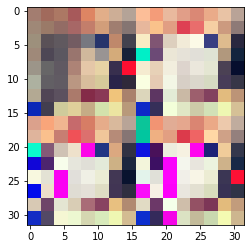

start training at 16x16
Current learning rate=3.906e-06
step= 0000, d_loss= 9.9969139099, g_loss= 17.7529582977, d_real= -17.7492179871, EM_dist= -0.0010752678


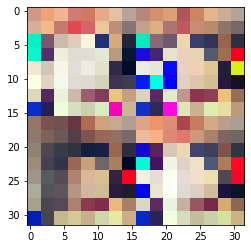

step= 0050, d_loss= 9.9935779572, g_loss= 17.7003974915, d_real= -17.6998863220, EM_dist= 0.0000147820


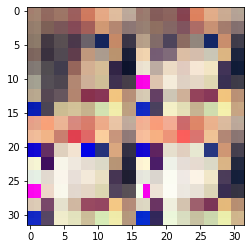

step= 0100, d_loss= 9.9951944351, g_loss= 17.6481704712, d_real= -17.6524200439, EM_dist= 0.0051136017


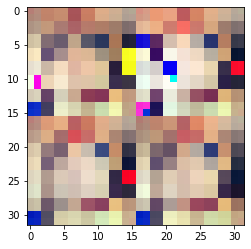

step= 0150, d_loss= 9.9960155487, g_loss= 17.6366348267, d_real= -17.6383934021, EM_dist= 0.0002303123


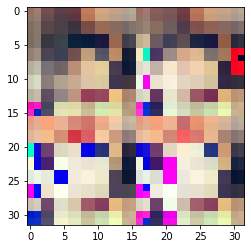

step= 0200, d_loss= 9.9948120117, g_loss= 17.5911560059, d_real= -17.5910758972, EM_dist= -0.0006346703


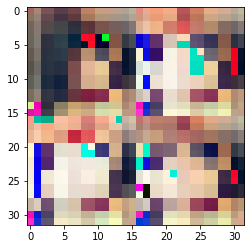

step= 0250, d_loss= 9.9951610565, g_loss= 17.5441551208, d_real= -17.5430488586, EM_dist= 0.0000901222


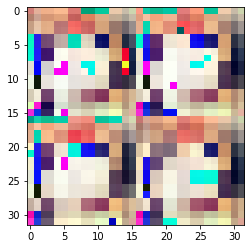

step= 0300, d_loss= 9.9963397980, g_loss= 17.5120201111, d_real= -17.5130195618, EM_dist= -0.0001182556


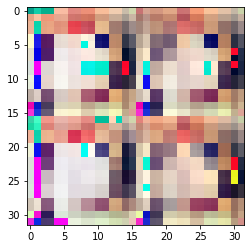

step= 0350, d_loss= 9.9951581955, g_loss= 17.4679298401, d_real= -17.4694709778, EM_dist= 0.0006723404


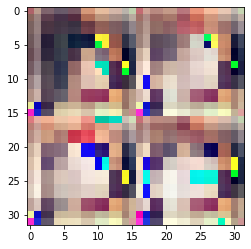

step= 0400, d_loss= 9.9920654297, g_loss= 17.4209098816, d_real= -17.4231052399, EM_dist= 0.0012316704


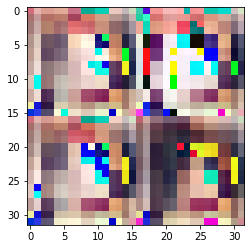

step= 0450, d_loss= 9.9930515289, g_loss= 17.3713054657, d_real= -17.3723926544, EM_dist= 0.0008592606


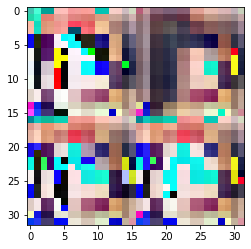

step= 0500, d_loss= 9.9945487976, g_loss= 17.3279514313, d_real= -17.3335990906, EM_dist= 0.0034542084


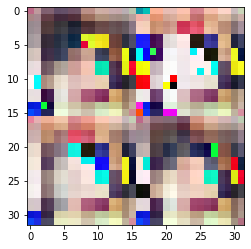

step= 0550, d_loss= 9.9954500198, g_loss= 17.2637844086, d_real= -17.2682209015, EM_dist= 0.0030508041


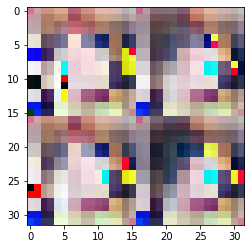

step= 0600, d_loss= 9.9906806946, g_loss= 17.2139854431, d_real= -17.2182350159, EM_dist= 0.0035066605


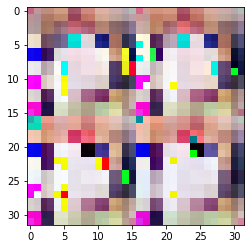

step= 0650, d_loss= 9.9891929626, g_loss= 17.1700744629, d_real= -17.1770820618, EM_dist= 0.0050373077


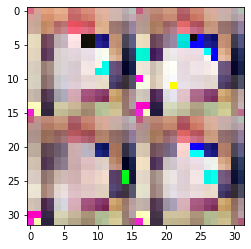

step= 0700, d_loss= 9.9871034622, g_loss= 17.1090507507, d_real= -17.1168975830, EM_dist= 0.0070533752


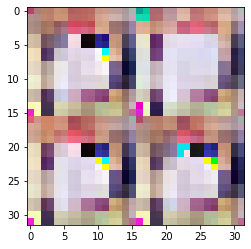

step= 0750, d_loss= 9.9852886200, g_loss= 17.0519886017, d_real= -17.0597743988, EM_dist= 0.0065522194


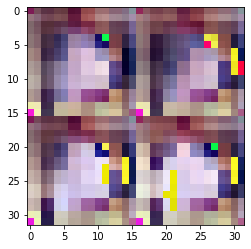

step= 0800, d_loss= 9.9967041016, g_loss= 17.0002593994, d_real= -17.0085182190, EM_dist= 0.0085878372


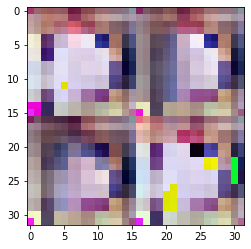

step= 0850, d_loss= 9.9906959534, g_loss= 16.9495925903, d_real= -16.9596691132, EM_dist= 0.0097255707


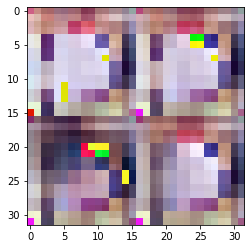

step= 0900, d_loss= 9.9953184128, g_loss= 16.8815174103, d_real= -16.8907470703, EM_dist= 0.0106811523


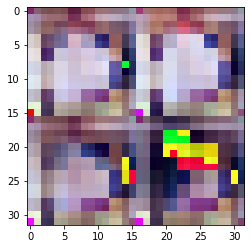

step= 0950, d_loss= 9.9819526672, g_loss= 16.8269271851, d_real= -16.8428688049, EM_dist= 0.0158629417


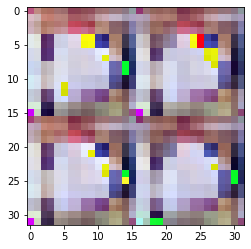

step= 1000, d_loss= 9.9971437454, g_loss= 16.7652702332, d_real= -16.7789268494, EM_dist= 0.0162401199


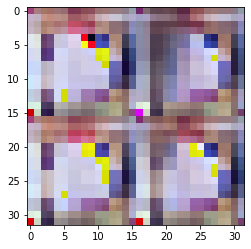

step= 1050, d_loss= 9.9786462784, g_loss= 16.6816425323, d_real= -16.7039337158, EM_dist= 0.0204162598


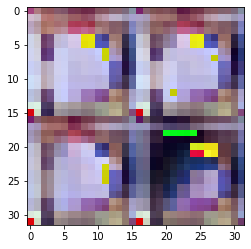

step= 1100, d_loss= 10.0025959015, g_loss= 16.6419067383, d_real= -16.6611881256, EM_dist= 0.0215849876


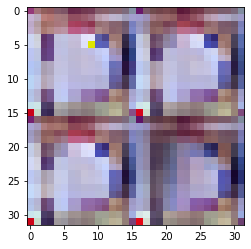

step= 1150, d_loss= 9.9532480240, g_loss= 16.5632171631, d_real= -16.5876750946, EM_dist= 0.0219650269


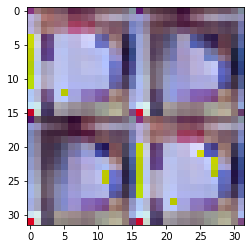

step= 1200, d_loss= 9.9536495209, g_loss= 16.5025062561, d_real= -16.5364723206, EM_dist= 0.0318679810


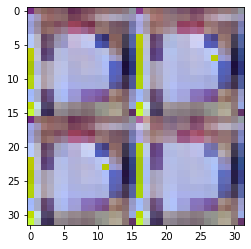

step= 1250, d_loss= 9.9734096527, g_loss= 16.4394569397, d_real= -16.4723701477, EM_dist= 0.0288329124


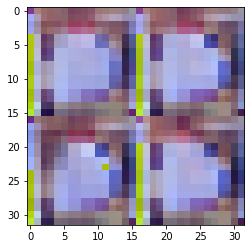

step= 1300, d_loss= 9.9915018082, g_loss= 16.3680725098, d_real= -16.4035072327, EM_dist= 0.0354337692


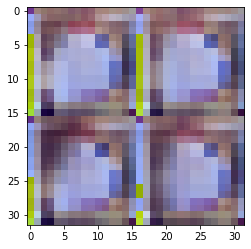

step= 1350, d_loss= 9.9403924942, g_loss= 16.2799835205, d_real= -16.3187675476, EM_dist= 0.0359153748


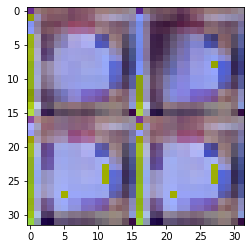

step= 1400, d_loss= 10.0066776276, g_loss= 16.2176361084, d_real= -16.2471179962, EM_dist= 0.0306000710


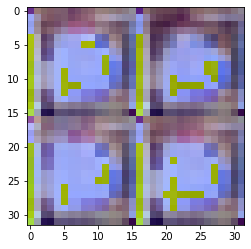

step= 1450, d_loss= 9.9585990906, g_loss= 16.1308193207, d_real= -16.1842670441, EM_dist= 0.0490593910


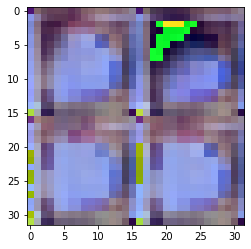

step= 1500, d_loss= 9.9851913452, g_loss= 16.0540618896, d_real= -16.1002407074, EM_dist= 0.0434150696


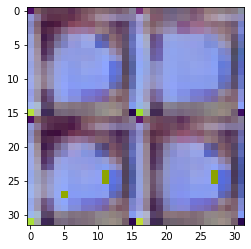

step= 1550, d_loss= 9.9589500427, g_loss= 15.9762229919, d_real= -16.0356521606, EM_dist= 0.0577642918


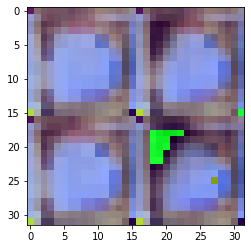

step= 1600, d_loss= 9.9527378082, g_loss= 15.9006710052, d_real= -15.9454040527, EM_dist= 0.0418937206


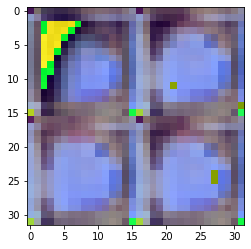

step= 1650, d_loss= 9.9424247742, g_loss= 15.8174829483, d_real= -15.8933334351, EM_dist= 0.0728449821


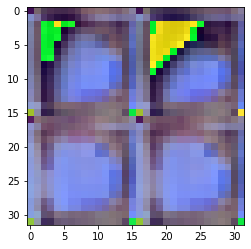

step= 1700, d_loss= 9.9604911804, g_loss= 15.7258033752, d_real= -15.7990036011, EM_dist= 0.0688331127


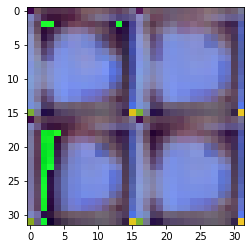

step= 1750, d_loss= 9.8468494415, g_loss= 15.6514606476, d_real= -15.7644920349, EM_dist= 0.1089584827


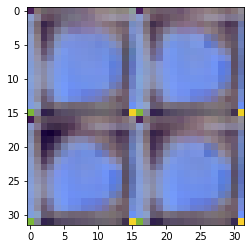

step= 1800, d_loss= 9.9126758575, g_loss= 15.5777168274, d_real= -15.6760406494, EM_dist= 0.0967428684


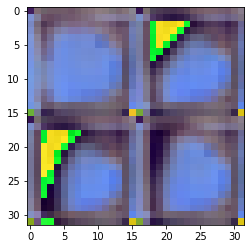

step= 1850, d_loss= 9.9280834198, g_loss= 15.4952659607, d_real= -15.5917940140, EM_dist= 0.0952279568


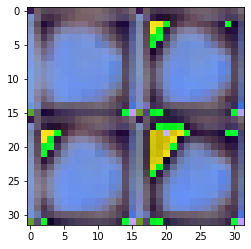

step= 1900, d_loss= 9.8307104111, g_loss= 15.3967971802, d_real= -15.5306463242, EM_dist= 0.1294391155


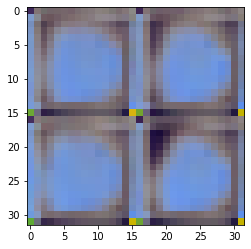

step= 1950, d_loss= 10.0127649307, g_loss= 15.3259010315, d_real= -15.4190826416, EM_dist= 0.0950896740


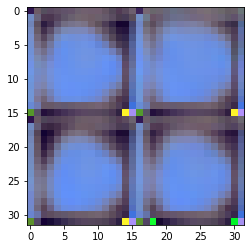

1999/5000 Alpha reaches 1.0
step= 2000, d_loss= 9.9159555435, g_loss= 15.2368898392, d_real= -15.3269748688, EM_dist= 0.0902214050


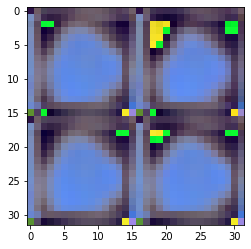

2043/5000 Interrupted
Train End


In [66]:
while (cur_res <= input_size):
    if (cur_res == 4):
        total_step=train_schedule[4]
    else:
        total_step=shift_step+train_schedule[cur_res]
        
    try:
        total_step-=resume_step
        alpha=alpha_increase*resume_step
    except NameError:
        pass
    
    try:
        for step in range(total_step+1):
            #准备数据
            if (cur_res > 4 and step == shift_step):
                print("Alpha reaches 1.0")
            print("\r%04d/%04d " % (step,total_step),end='')
            alpha+=alpha_increase
            x=next(data_iter)[0]
            x=process_real_image(x,cur_res,alpha)

            #训练
            d_loss,d_real,W = D_train_step(G,D,x,alpha)
            g_loss = G_train_step(G,D,x,alpha)
            ReduceLR.watch(W)

            #可视化与保存
            if step%50 == 0 :
                print("\rstep= %04d, d_loss= %.10f, g_loss= %.10f, d_real= %.10f, EM_dist= %.10f"
                          % (step,float(d_loss),float(g_loss),float(d_real),W))
                noise= np.float32(np.random.normal(0,1,(batch_size,z_dim)))
                img_path=os.path.join(re_dir,"PGGAN{0}x{0}_{1:04d}.jpg".format(cur_res,step))
                visualize_result(G,[noise,alpha],save_path=img_path,save=True,rewind=False)

                if (step%100 == 0 and step != 0):
                    #保存
                    D_path,G_path=get_ckpt_path(cur_res)
                    D.save_weights(D_path)
                    G.save_weights(G_path)


        if (cur_res*2 > input_size): break

        print('change resolution from %d to %d' % (cur_res,cur_res*2))
        D_path,G_path=get_ckpt_path(cur_res)
        D.save_weights(D_path)
        G.save_weights(G_path)

        resume_step=0
        alpha=0.0
        cur_res*=2
        D,G=prepare_model(cur_res,load=True)
        ReduceLR.on_shifting()
        visualize_result(G,[noise,alpha], save=False,rewind=True)
        print('start training at {0}x{0}'.format(cur_res))
        print("Current learning rate=%.3e" % (cur_lr))
    except KeyboardInterrupt:
        train_sch.pause_train()
        print("Interrupted")
        break
            
print("Train End")